# Zillow Regression Project 
# Insert Snappy Title Here

In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pydataset import data

import wrangle as w
import explore as ex
import evaluate as ev


from scipy import stats
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [12]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Acquire / Prepare
#### Goals
- get data 
- look at and deal with nulls and duplicates
- understand what I'm looking at

In [29]:
# get data using sql query and wrangle function

df = w.get_zillow_data()

In [30]:
# take a peak at data
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,garage_car_count,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,NaN,NaN,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,1.0,NaN,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,NaN,NaN,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,NaN,2.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,NaN,NaN,6037.0,1399.27,2017-08-23


In [31]:
# look at column info see if there's anything need to change as far as types
# can see some nulls
# need to change date to a datetime object 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         28124 non-null  int64  
 1   tax_value         28123 non-null  float64
 2   bathroom_cnt      28124 non-null  float64
 3   bedroom_cnt       28124 non-null  float64
 4   sqft_calculated   28077 non-null  float64
 5   has_pool          6130 non-null   float64
 6   garage_car_count  9953 non-null   float64
 7   fips              28124 non-null  float64
 8   tax_amount        28123 non-null  float64
 9   transaction_date  28124 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.4+ MB


In [32]:
# change transaction_date to datetime object
# line is in wrangle.py
df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [33]:
df.duplicated().value_counts()

False    28124
dtype: int64

In [34]:
w.missing_values_table(df)

Your selected dataframe has 10 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
has_pool,21994,78.2
garage_car_count,18171,64.6
sqft_calculated,47,0.2
tax_value,1,0.0
tax_amount,1,0.0


#### Takeaways Nulls / Dupes
- There are no duplicate rows! 
- Missing values in pool and garage car count will be filled with 0
- Garage car count will be changed to new boolian variable has_garage
    - anything over 1 will be changed to 1 any 0s or NaNs will be 0s
- Not too many missing values. Will drop rows with missing values after cleaning pool and garage variables
    - 47 sqft missing - DROP
    - 1 tax_value - DROP
    - 1 tax_amount DROP (thought about keeping it just for modeling and throwing it out for county tax info but it's just 1 row)

In [35]:
# fill nans with 0s
# add to function
df['has_pool'] = df.has_pool.fillna(value=0)

In [36]:
# fill nas with 0s for garage
df.garage_car_count.fillna(value=0, inplace=True)

# add new column has garage as boolian. anything over 1 is having a garage, 0 no garage
# ad to function
df['has_garage'] = (df.garage_car_count != 0).astype(int)

In [37]:
#drop the rows with NaNs
df.drop(df[df.isna().any(axis=1)].index, inplace=True)

In [38]:
# look at unique values in each column
for col in df.drop(columns=['parcel_id', 'tax_value', 'tax_amount']).columns:
    print(f'---------------')
    print(f'There are {df[col].nunique()} unique values in the {col} column')

---------------
There are 20 unique values in the bathroom_cnt column
---------------
There are 13 unique values in the bedroom_cnt column
---------------
There are 4055 unique values in the sqft_calculated column
---------------
There are 2 unique values in the has_pool column
---------------
There are 14 unique values in the garage_car_count column
---------------
There are 3 unique values in the fips column
---------------
There are 119 unique values in the transaction_date column
---------------
There are 2 unique values in the has_garage column


#### 1 bathroom and 0 bedrooms with sqftage might be a studio! I will keep those in

#### 0 Bathroom and 0 (or any number of) bedrooms with sqftage will be dropped. can't guess how many beds and bathrooms those have

In [39]:
total_rows = df.shape[0] 
rows_with =  df[df.bathroom_cnt == 0].shape[0]

print(f'There are {total_rows} total rows, {rows_with} with 0 in the bathroom_cnt column.')
print(f'If we drop these rows there should be {total_rows-rows_with} rows left')
print(f'It\'s {rows_with/total_rows:.2%} of the data')

There are 28075 total rows, 23 with 0 in the bathroom_cnt column.
If we drop these rows there should be 28052 rows left
It's 0.08% of the data


In [40]:
# drop the rows with the 0 bathroom count
df.drop(df[df.bathroom_cnt == 0].index, inplace=True)

# check shape
df.shape

(28052, 11)

### Target
- tax_value

### Variables 
#### Categorial variables:
- fips
- bedrooms
- bathrooms 

EXTRA features
- has_pool
- has_garage

#### Continous variables:
- sqft_calculated
- transaction_date 

#### Other
- parcel_id - unique identifer
- tax_amount - not used for modeling

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore 
#### Goals 
- Univariate exploration 
    - find and deal with outliers
- train, validate, test split
- Multivariate exploration
- Vizualize relationship between variables and target
- Find Drivers
- State Hypotheses and run some Statistical Tests


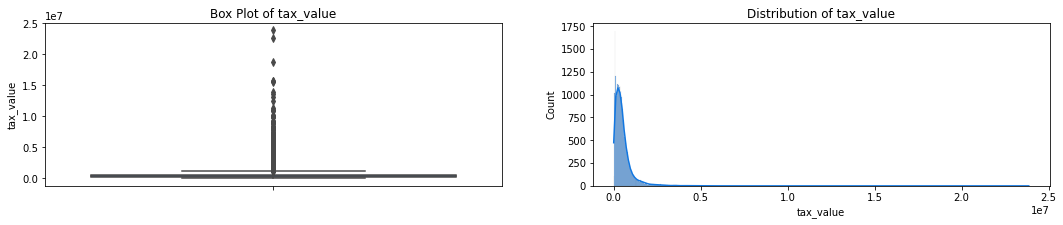

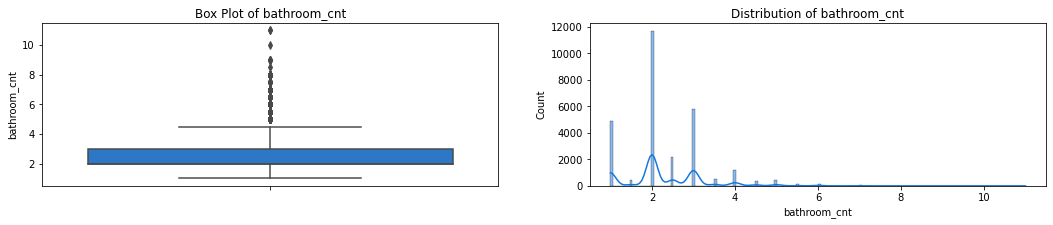

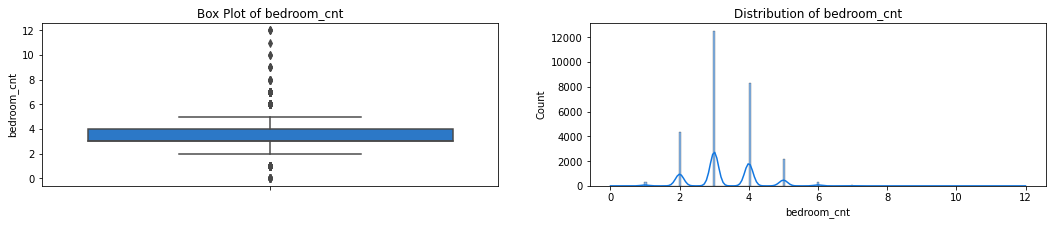

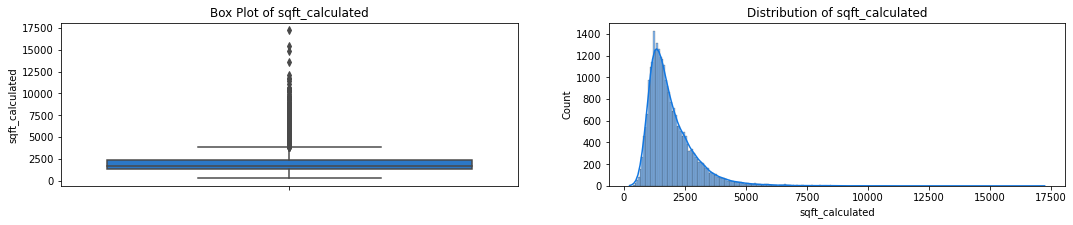

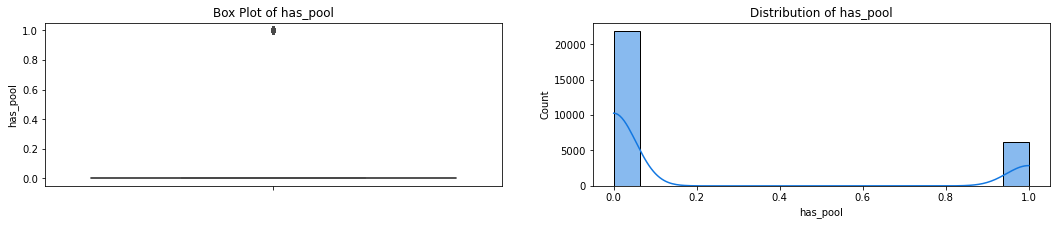

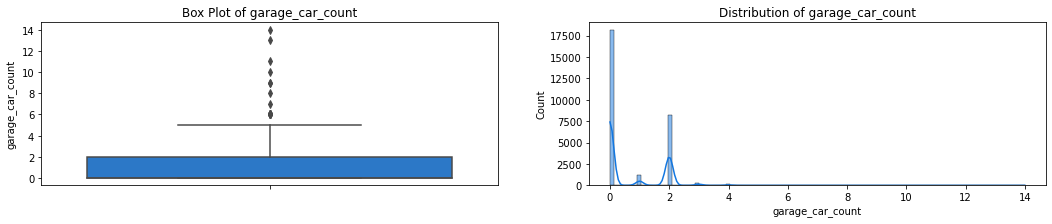

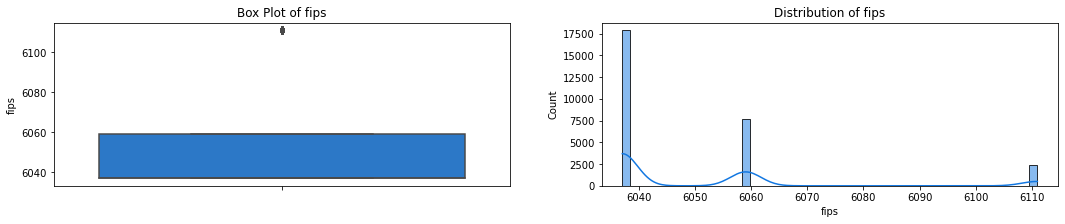

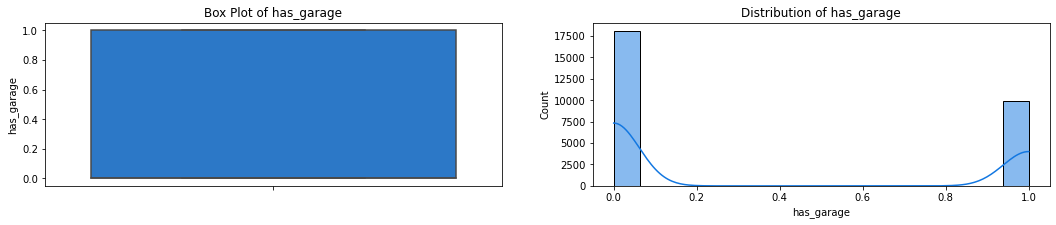

In [41]:
# use function from explore to look at distributions
ex.explore_univariate(df.drop(columns=['parcel_id', 'transaction_date', 'tax_amount']))

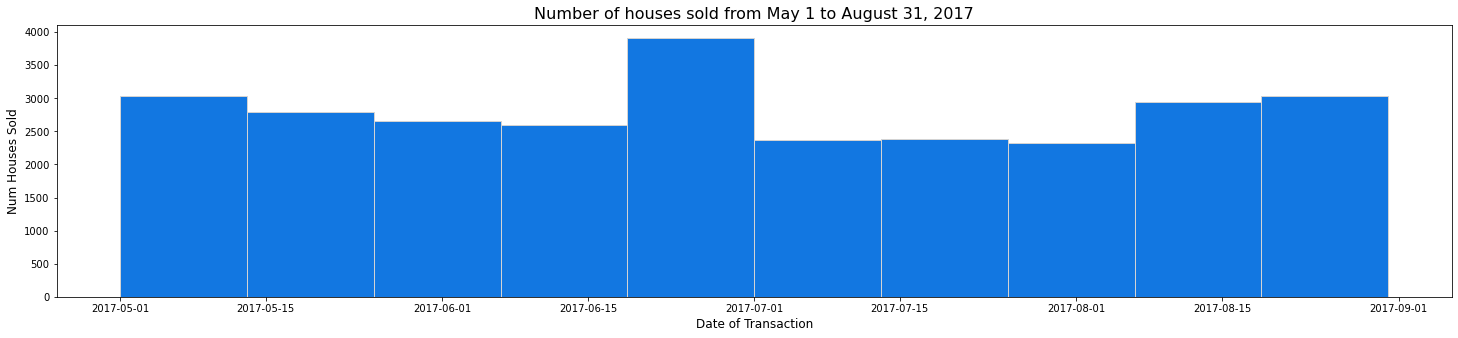

In [42]:
# plot dates houses were sold
plt.figure(figsize=(25, 5))
plt.hist(df.transaction_date, lw = 1, ec = 'lightgrey')
plt.xlabel('Date of Transaction', fontsize = 12)
plt.ylabel('Num Houses Sold', fontsize = 12)
plt.title('Number of houses sold from May 1 to August 31, 2017', fontsize = 16)
plt.show()

### Takeaways
- Need to drop outliers
    - drop outliers in bedroom_cnt, bathroom_cnt, and sqft_calculated with absolute value z_score above 3
    - done in wrangle file
- most of the houses are in LA county (fips 6037)
- The second half of June 2017 saw higher number of house sales

### Train, Validate, Test Split and Bivarate Exploration

In [43]:
# get data with wrangle function, all things above dealt with
df = w.wrangle_zillow()

In [44]:
train, validate, test = w.banana_split(df)

train --> (15349, 10)
validate --> (6579, 10)
test --> (5483, 10)
